In [31]:
from nlp_ai_utils import *
from chunks_urls import CHUNKS_URLS
from updating_values import DATA_LIMIT

In [32]:
#set this variable to true if you are using light more, or false if you are using dark mode.
JUPYTER = False
RANDOM_STATE = 42

In [33]:
TF_ENABLE_ONEDNN_OPTS = 0
URLS = CHUNKS_URLS
LIMIT = DATA_LIMIT
LARGER_DATASET_PATH = "../larger_dataset"
PREPROCESSED_CHUNKS_PATH = LARGER_DATASET_PATH + "/preprocessed_data_chunks/"
BASE_FILE_NAME = "chunk_"
FILE_FORMAT = ".csv"
ACTUAL_DATA_SHAPE = 6990280
RANDOM_STATE = 42

### 1.1 Data Sourcing and Munging

#### 1.1.1 Utility Functions

In [34]:
if not os.path.exists(LARGER_DATASET_PATH):
    os.mkdir(LARGER_DATASET_PATH)
if not os.path.exists(PREPROCESSED_CHUNKS_PATH):
    os.mkdir(PREPROCESSED_CHUNKS_PATH)
get_chunks(URLS,LIMIT,1,BASE_FILE_NAME,PREPROCESSED_CHUNKS_PATH,FILE_FORMAT)

chunk_1 already exists.
chunk_2 already exists.
chunk_3 already exists.
chunk_4 already exists.
chunk_5 already exists.
chunk_6 already exists.


In [35]:
#get all names of downloaded files
all_file_names = get_all_file_names(BASE_FILE_NAME,LIMIT)

In [36]:
#read all chunks into a list
list_dfs = read_chunks(all_file_names,PREPROCESSED_CHUNKS_PATH,FILE_FORMAT)

In [37]:
#concatenate all chunks into a singular df
df = group_up_chunks(list_dfs)

In [38]:
#check how much of the data was actually downloaded
percent_loaded = check_no_missing_data(df.shape[0],ACTUAL_DATA_SHAPE)
percent_loaded

10.000028611157207

In [39]:
df.columns

Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date'],
      dtype='object')

In [40]:
review_data = df[['text', 'stars']].copy()

In [41]:
review_data

,text,stars
0,decide eat aware go take 2 hour begin end try ...,3.0
1,ve take lot spin class year nothing compare cl...,5.0
2,family diner buffet eclectic assortment large ...,3.0
3,wow yummy different delicious favorite lamb cu...,5.0
4,cute interior owner give u tour upcoming patio...,4.0
...,...,...
116500,m thrill discover wonderful french pastry dess...,5.0
116501,excite hopeful try restaurant new owner since ...,3.0
116502,like visit gator treasure island plenty indoor...,4.0
116503,cool night new orleans set night early dinner ...,4.0


In [42]:
review_data.reset_index(inplace = True)
review_data.drop(['index'],axis = 1,inplace = True)

In [43]:
review_data.rename(columns = {'text':'full_review_text','stars':'star_rating'}, inplace = True)

In [44]:
review_data

,full_review_text,star_rating
0,decide eat aware go take 2 hour begin end try ...,3.0
1,ve take lot spin class year nothing compare cl...,5.0
2,family diner buffet eclectic assortment large ...,3.0
3,wow yummy different delicious favorite lamb cu...,5.0
4,cute interior owner give u tour upcoming patio...,4.0
...,...,...
699025,m thrill discover wonderful french pastry dess...,5.0
699026,excite hopeful try restaurant new owner since ...,3.0
699027,like visit gator treasure island plenty indoor...,4.0
699028,cool night new orleans set night early dinner ...,4.0


In [45]:
review_data.isnull().sum()

full_review_text    2
star_rating         0
dtype: int64

In [46]:
review_data.dropna(inplace = True)

In [47]:
review_data['full_review_text'].replace('', np.nan, inplace=True)
review_data.dropna(inplace = True)

In [48]:
review_data['full_review_text'] = [new_text.lstrip('0123456789.- ') for new_text in review_data['full_review_text']]
review_data['full_review_text'] = [new_text.lstrip('s') for new_text in review_data['full_review_text']]

Text(0.5, 1.0, 'Word Cloud of Unique Words')

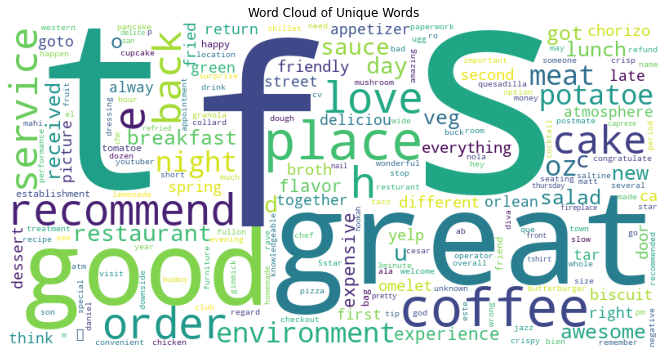

In [49]:
# Extract unique words from the text data
if os.path.exists("../pickle_files/unique_words.pickle"):
    unique_words = pickle.load(open("../pickle_files/unique_words.pickle",'rb'))
else:
    unique_words = set(' '.join(review_data['full_review_text']).split())

# Create a word cloud of the unique words
unique_wordcloud = WordCloud(width=800, height=400, background_color='white',random_state = RANDOM_STATE).generate(' '.join(unique_words))
plt.figure(figsize=(12, 6))
plt.imshow(unique_wordcloud)
plt.axis('off')
plt.title('Word Cloud of Unique Words')

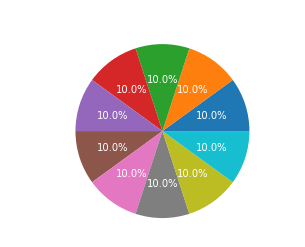

In [50]:
# count word occurrences and store them
word_counts = collections.Counter(list(unique_words))

# Get the most common words and their counts
most_common = word_counts.most_common(10)
labels = [word[0] for word in most_common]
values = [word[1] for word in most_common]

# Create the pie chart
if JUPYTER:
    color = "black"
else:
    color = "white"
plt.pie(values, labels=labels, autopct='%1.1f%%', textprops={'color': color})
plt.title('Most Common Words',color=color)
plt.show()

Text(0, 0.5, 'Word')

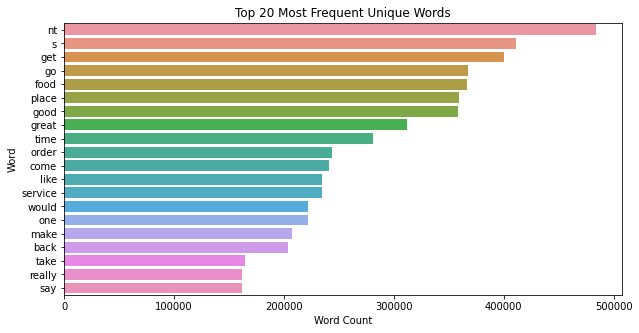

In [51]:
# Count the number of occurrences of each unique word and create a bar chart of the top 20 most frequent unique words
unique_word_count = review_data['full_review_text'].str.split(expand=True).stack().value_counts()
top_unique_words = unique_word_count.loc[unique_word_count.index.isin(unique_words)].head(20)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_unique_words.values, y=top_unique_words.index)
plt.title('Top 20 Most Frequent Unique Words')
plt.xlabel('Word Count')
plt.ylabel('Word')

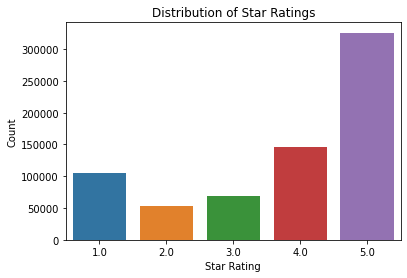

In [52]:
# Create a countplot of the star ratings using Seaborn
sns.countplot(x=review_data['star_rating'])

# Add some labels and titles
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.title('Distribution of Star Ratings')

# Show the plot
plt.show()

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


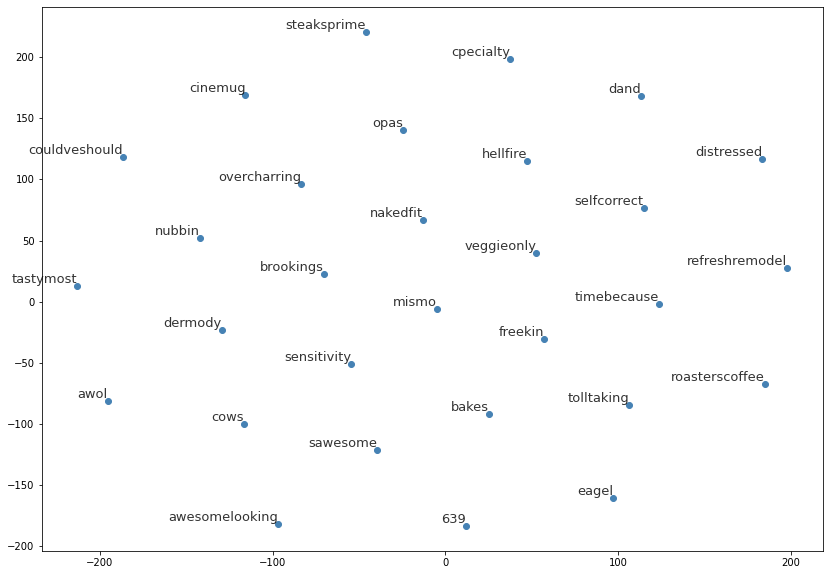

In [53]:
#Visualizing the word vector space of the dataset
vectorizer = CountVectorizer()
if os.path.exists('../pickle_files/word2vec_model_sklearn.pickle'):
    word_embedding = pickle.load(open('../pickle_files/word2vec_model_sklearn.pickle','rb'))
else:
    word_embedding = vectorizer.fit_transform(review_data['full_review_text'])
viz_words = 30
tsne = TSNE()
embed_tsne = tsne.fit_transform(word_embedding[:viz_words, :])
fig, ax = plt.subplots(figsize=(14, 10))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    int_to_vocab = {i: word for i, word in enumerate(set(unique_words))}
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.8, fontsize=13, color='black', horizontalalignment='right', verticalalignment='bottom')